### Import Python libraries

In [1]:
%matplotlib inline 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy import stats
from scipy.stats import zscore
from sklearn.preprocessing import scale 
from sklearn import cross_validation
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

/Users/emilyhahn/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load and preprocess data

In [2]:
### Import data ###
df=pd.DataFrame.from_csv('INCA_data_V3.csv',index_col=None)
        
### Set static variables ###
static_vars = df.iloc[:,5:50]

### Parse VR values (until NaN issue resolved) ###
V_VR = [df[['v_sig']]]
A_VR = [df[['a_sig']]]

###-------------###

### Parse VR values to test independently ###
# V_VR = [df[['v_sig']], df[['v_ctrl_lab']]]
# A_VR = [df[['a_sig']], df[['a_ctrl_lab']]] 

# df=df.round(0)
# s=np.all(np.isnan(df))

### Scale IN vals and static vars ###
# for column in df:
#     df[column]=scale(df[column])

### Initialize LASSO functions

In [3]:
def lasso(X,y):
    
    # Generate alphas (lin, log are same space)
    alphas = 10**np.linspace(1,-2,36)*0.5
#     alphas = np.logspace(1,-2,36)*0.5

    # Split train and test data
    X_train, X_test , y_train, y_test = \
    cross_validation.train_test_split(X, y, test_size=.5, random_state=None) 

    # Train and plot lasso model
    lasso = Lasso(max_iter=100000)
    coefs = [] 

    for a in alphas: 
        lasso.set_params(alpha=a) 
        lasso.fit(X_train, y_train)
        coefs.append(lasso.coef_)

    ax = plt.gca()
    ax.plot(alphas, coefs)
    ax.set_xscale('log')   
    plt.axis('tight') 
    plt.xlabel(r'alpha $\alpha$') 
    plt.ylabel('weights (coefs)')
    plt.title('y = %s | x = static_vars + %s' % (y.name,X.columns[0]))
    ax.legend(labels=pd.Series(X.columns), \
              loc=0, bbox_to_anchor=(1.3, .75)) 
    plt.show()

    # Choose the best alpha using cross validation (CV)
    lassocv = LassoCV(cv=18, max_iter=100000) 
    params = lassocv.fit(X_train, y_train)

    # Refit lasso model
    ref_lasso_cv = lasso.set_params(alpha=lassocv.alpha_) 
    ref_params = lasso.fit(X_train, y_train) 
    
    # R2 score
#     y_pred_lasso = lasso.fit(X_train, y_train).predict(X_test)
#     r2_score_lasso = r2_score(y_test, y_pred_lasso)
#     print("r^2 on test data : %f\n" % r2_score_lasso)

    # Compute error
    mse = mean_squared_error(y_test, lasso.predict(X_test))

    # CV alpha
    cv_alpha = lassocv.alpha_
    print('MSE: %f \n\nCV alpha: %f \n\nCV params: \n\n%s\n' % (mse, cv_alpha, params))
    
    # LASSO params
    print('LASSO params: \n\n%s\n' % ref_params)

    # Coef estimates
    ce = pd.Series(lasso.coef_, index=X.columns)
    print('lasso coefficient estimates: \n%s' % ce)
        
    # Sparse coef estimates
#     sce = pd.Series(lasso.sparse_coef_, index=X.columns)
#     print('lasso sparse coefficient estimates: \n%s' % sce) 
    
    return

In [4]:
def lasso_IN(X_group,y_predictor,static_vars):
    for var in X_group:
        y_var = y_predictor
        X_var = pd.concat([var,static_vars], axis=1)
        lasso(X_var,y_var)
    return

### Independly test VR values - valence, arousal

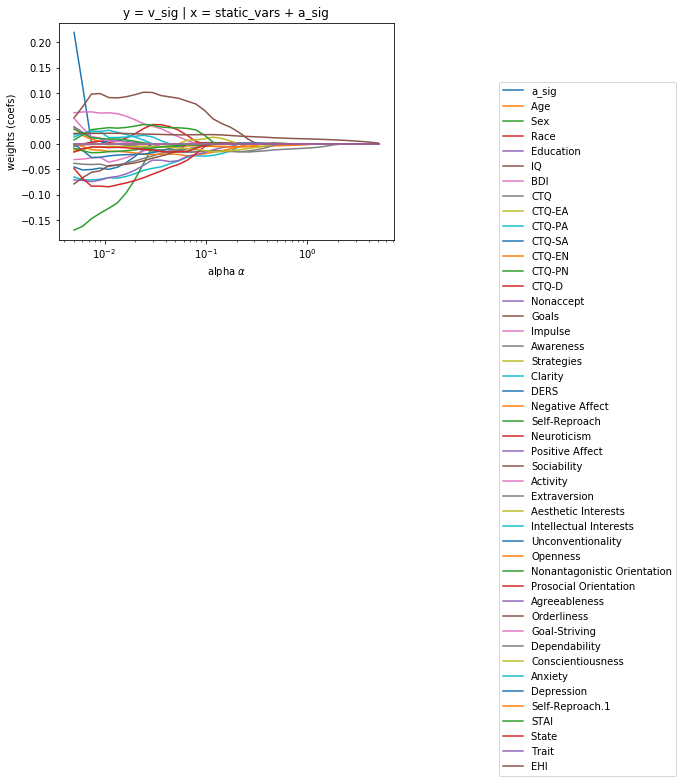

MSE: 0.373250 

CV alpha: 0.823562 

CV params: 

LassoCV(alphas=None, copy_X=True, cv=18, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

LASSO params: 

Lasso(alpha=0.82356235907801001, copy_X=True, fit_intercept=True,
   max_iter=100000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

lasso coefficient estimates: 
a_sig                          0.000000
Age                           -0.002300
Sex                           -0.000000
Race                          -0.000000
Education                     -0.000000
IQ                             0.000000
BDI                            0.000000
CTQ                           -0.009201
CTQ-EA                        -0.000000
CTQ-PA                        -0.000000
CTQ-SA                        -0.000000
CTQ-EN    

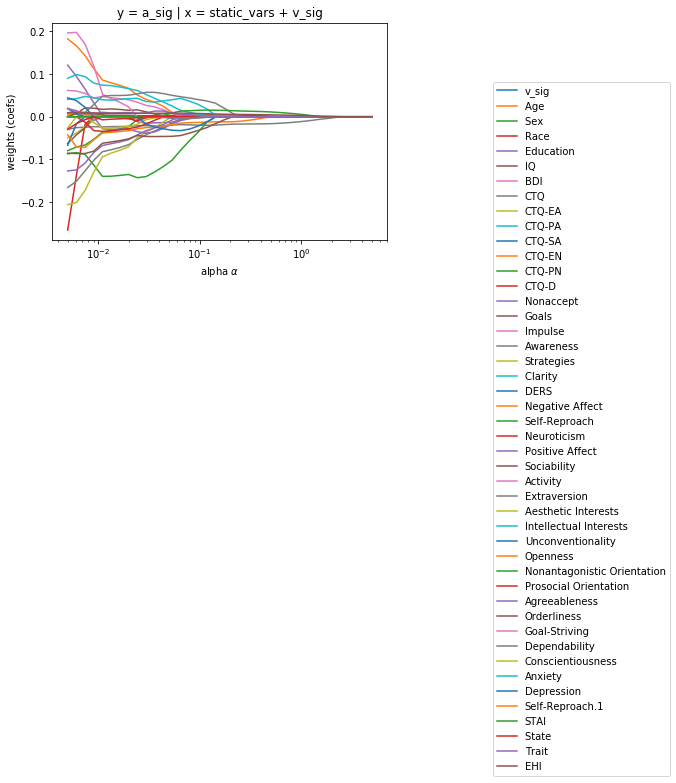

MSE: 0.309862 

CV alpha: 0.821546 

CV params: 

LassoCV(alphas=None, copy_X=True, cv=18, eps=0.001, fit_intercept=True,
    max_iter=100000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

LASSO params: 

Lasso(alpha=0.82154609899178554, copy_X=True, fit_intercept=True,
   max_iter=100000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

lasso coefficient estimates: 
v_sig                          0.000000
Age                           -0.000000
Sex                           -0.000000
Race                          -0.000000
Education                      0.000000
IQ                             0.000000
BDI                            0.000000
CTQ                           -0.013176
CTQ-EA                        -0.000000
CTQ-PA                        -0.000000
CTQ-SA                        -0.000000
CTQ-EN    

In [5]:
###---------------------### 
# OPTIMIZATION OBJECTIVE
# (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1 
###---------------------### 

### valence | IN fMRI values (SVM output) vs cog-behav variables
lasso_IN(A_VR,df['v_sig'],static_vars)

### arousal | IN fMRI values (SVM output) vs cog-behav variables
lasso_IN(V_VR,df['a_sig'],static_vars)

In [ ]:
# ###---------------------### 
# # OPTIMIZATION OBJECTIVE
# # (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1 
# ###---------------------### 

# ### valence | IN fMRI values (SVM output) vs cog-behav variables
# lasso_IN(A_VR,df['v_sig'],static_vars)

# ### arousal | IN fMRI values (SVM output) vs cog-behav variables
# lasso_IN(V_VR,df['a_sig'],static_vars)